# Imputation for Dynamical Systems: A crash course
This tutorial serves as an introduction to the paper {cite}`fim_dynamical_systems` and its accompanying code. This page shortly explains the paper and the usage of our trained models. The next pages describe the features seen here in more detail and will allow you to use our models on your own data!
- [Missing Values](imputation_missing_values.ipynb)
- [Missing temporal pattern](imputation_missing_patterns.ipynb)
## Introduction 

Dynamical systems are mathematical systems that change with time according to a fixed evolution rule, and serve as representational and analytical tools for  
phenomena which generate patterns that change over time.
Very often, the recorded changes of these empirical patterns are such that they can be viewed as occurring continuously in time, and thus can be represented mathematically by systems whose evolution rule is defined through differential equations.
Dynamical systems governed by ordinary differential equations (ODEs) correspond to an important subset of these models,
and describe the rate of change of a single parametric function 
$\mathbf{x}: \mathbb{R}^+ \rightarrow \mathbb{R}^D$, 
which represents the state of the ($D$-dimensional) system, as time evolves, by means of a vector field 
$\mathbf{f}: \mathbb{R}^+ \times \mathbb{R}^D  \rightarrow \mathbb{R}^D$.

In equations, we write
```{math}
\mathbf{\dot x}(t) = \mathbf{f}(t, \mathbf{x}(t)), \, \,  \text{where} \, \, \, \mathbf{\dot x}(t) = \frac{d \mathbf{x}(t)}{dt}.
```

We consider the general problem of imputing missing values in time series data, recorded from some empirical process $(\mathbf{y}^*: \mathbb{R}^+ \rightarrow \mathbb{R}^D)$ whose dynamics are *assumed* to be governed by some unknown ODE.
In other words, we assume that both available and missing values in the series $\mathbf{y}^*(\tau_1), \dots, \mathbf{y}^*(\tau_l)$ correspond to the values taken by *the solution* $\mathbf{x}(t)$ of some hidden ODE, at the observation times $\tau_1, \dots, \tau_l$, potentially corrupted by some noise signal of which only a few statistics are known.
Therefore, the goal is to infer the ODE solution $\mathbf{x}(t)$ that best *interpolates* the noisy time series $\mathbf{y}^*(\tau_1), \dots, \mathbf{y}^*(\tau_l)$ *and hence imputes its missing values*.

In lieu of training one complex model on a single empirical process, we trained a neural recognition model *offline* to infer a *large and varied set* of ODE solutions $\mathbf{x}(t)$, from a synthetic dataset that is composed of noisy series of observation on those solutions, displaying different missing value patterns.

## Two formulations of imputation problems

The classical formulation of the imputation problem typically involves different missing patterns and 
we will focus on two of them here. The first one is the so-called *point-wise missing pattern*, where individual vectors in the series randomly lack some of their components. The second one is the *temporal missing pattern*, where certain components of the vectors in the series are missing over consecutive observation times. To handle them, we make the following two simple assumptions.
- for the *point-wise missing pattern*, we assume one can always find a certain time scale $\tau_{\small\text{ simple}}$, or some (sequential) subset of observations, for which the best interpolating ODE solution is  "simple". Furthermore, we assume that the set of all such simple parametric functions can be well-represented by a heuristically constructed synthetic distribution. 
- for *temporal missing pattern*, assume the time series *featuring temporal missing patterns*  
involve more complex interpolating functions, meaning that no such $\tau_{\small\text{ simple}}$ is to be found in this case. Although more complex in nature, we assume that these functions are *locally* "simple", and that they often exhibit generic secular and seasonal structures, which encode important information about the missing values and can be well-represented by a second, synthetic distribution over parametric functions.

These two problem setting are solved by two different models, called $\texttt{FIM-}\ell$ and $\texttt{FIM}$, which we will use in the next pages to solve some toy example problems!


We can see this distinction in action in the following code snippets, which will sketch the usage of these two models on some simple dataset. 

:::{warning}
Since this page is only meant to sketch the capabilities of the models, we import the somewhat lengthy functions prepare_data and prepare_data_base. These can found in the repo or slightly adapted the later pages 
- [Missing Values](imputation_missing_values.ipynb)
- [Missing temporal pattern](imputation_missing_patterns.ipynb)
:::

Similar to the MJP model, we first import some classes from the FIM library and load the model from Hugging face. 

:::{note}
In practice, you probably want to use your GPU for most computations. To do so you need to put both the tensors containing the data and the model on the device, similarly to the MJP case, since our model supports torch syntax,  you can simple use ```mode.to(device)``` with the appropriate device!
:::

In [6]:
from tutorial_helper import prepare_data, prepare_data_base, visualize_prediction
from fim.models.imputation import FIMImputationWindowed, FIMImputationWindowedConfig
import torch
model = FIMImputationWindowed.from_pretrained("FIM4Science/fim-windowed-imputation")
base_model=model.fim_imputation.fim_base

We now generate some simple polynomial data, to which we add some gaussian noise. We also define the ```mask``` tensor, which contains the value True at all indices which our model should not see.

In [7]:
ts = (torch.arange(0, 10, step=0.1) - 3).reshape(1, 1, 100, 1)
true_values = torch.square(ts) - ts 
noisy_values = true_values + torch.normal(0, 2.5, size=true_values.shape)
mask = torch.zeros_like(ts).bool()

For the point-wise missing data, we access the base model and use it to predict the missing values, i.e. the values at the indices where the mask tensor has the value ```True```. To showcase this we manually flip some of the values of the mask tensor:

In [8]:
mask[0,0,[1,5,19,70],0]=True

After which we use the ```prepare_data_base``` function to format the data for the base model $\texttt{FIM-}\ell$. We then call $\texttt{FIM-}\ell$ on the created data to get the imputed values:

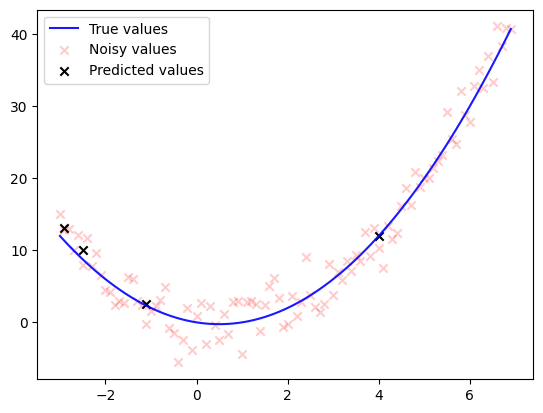

In [9]:
base_batch = prepare_data_base(ts, noisy_values, mask)
base_model.eval()
with torch.no_grad():
    prediction = base_model(base_batch)["visualizations"]["solution"]["learnt"].flatten() # Shape [1, 100, 1] -> shape [100]
visualize_prediction(ts.flatten(),true_values.flatten(),noisy_values.flatten(),prediction,mask.flatten())

Similarly, we can use the $\texttt{FIM}$ model to impute values in the case of a temporal missing pattern i.e. when values are missing over a longer timeframe for which we now longer assume a simple structure of the underlying dynamic. We will use the sine function to generate example a simple example dataset and impute some missing data using the $\texttt{FIM}$ model:

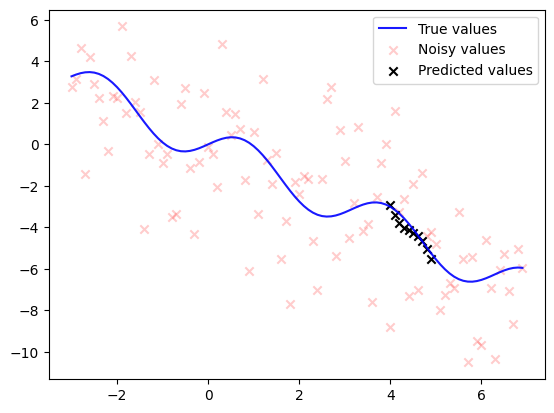

In [10]:
true_values_temporal = torch.sin(2*ts) - ts 
noisy_values_temporal = true_values_temporal + torch.normal(0, 2.5, size=true_values.shape)
mask_temporal = torch.zeros_like(ts).bool()
mask_temporal[0,0,[i for i in range(70,80)],0]=True
batch=prepare_data(ts,true_values_temporal,mask_temporal,imp_start=70,imp_end=80)
with torch.no_grad():
    prediction_temporal=model(batch)["imputation_window"]["learnt"].flatten()
visualize_prediction(ts.flatten(),true_values_temporal.flatten(),noisy_values_temporal.flatten(),prediction_temporal,mask_temporal.flatten())